<a href="https://colab.research.google.com/github/eminshall/Reinforcment-Learning-Agent-for-Stock-Trading-AAPL/blob/main/RL_Trading_Agent_4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/DLR-RM/stable-baselines3@feat/gymnasium-support
!pip install git+https://github.com/Stable-Baselines-Team/stable-baselines3-contrib@feat/gymnasium-support

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DLR-RM/stable-baselines3 (to revision feat/gymnasium-support) to /tmp/pip-req-build-tbrduaaj
  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-tbrduaaj
  Running command git checkout -q feat/gymnasium-support
  error: pathspec 'feat/gymnasium-support' did not match any file(s) known to git
  error: subprocess-exited-with-error
  
  × git checkout -q feat/gymnasium-support did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git checkout -q feat/gymnasium-support did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Looking in indexes: https://pypi.org/

In [ ]:
pip install gym-anytrading

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 18.8 MB/s eta 0:00:00


In [ ]:
pip install shimmy>=0.2.1

In [ ]:
!pip install finta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.1 MB/s eta 0:00:00


In [ ]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

#Quant Finance
from finta import TA
import quantstats as qs

# Processing libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

with open('/content/drive/MyDrive/key.txt', 'r') as f:
    key = f.readline()

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive/


In [ ]:
#Download 3 months of data (Alphavantage only provides 1 month per call)
month_1 = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=AAPL&interval=5min&slice=year1month1&apikey={key}&datatype=csv'
month_2 = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=AAPL&interval=5min&slice=year1month2&apikey={key}&datatype=csv'
month_3 = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=AAPL&interval=5min&slice=year1month3&apikey={key}&datatype=csv'
month_4 = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=AAPL&interval=5min&slice=year1month4&apikey={key}&datatype=csv'

#Grab the Data as CSV
csv_1 = pd.read_csv(month_1)
csv_2 = pd.read_csv(month_2)
csv_3 = pd.read_csv(month_3)
csv_4 = pd.read_csv(month_4)

#Put it into a DataFrame
data_1 = pd.DataFrame(csv_1)
data_2 = pd.DataFrame(csv_2)
data_3 = pd.DataFrame(csv_3)
data_4 = pd.DataFrame(csv_4)


#Append the three months into one Dataframe
data = data_1.append([data_2, data_3, data_4])

data.head(3)

<ipython-input-8-c96c229e7b18>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_1.append([data_2, data_3, data_4])


,time,open,high,low,close,volume
0,2023-05-05 20:00:00,173.18,173.19,173.08,173.08,20899
1,2023-05-05 19:55:00,173.17,173.20,173.16,173.16,9347
2,2023-05-05 19:50:00,173.16,173.17,173.15,173.16,3060


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15306 entries, 0 to 3590
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    15306 non-null  object 
 1   open    15306 non-null  float64
 2   high    15306 non-null  float64
 3   low     15306 non-null  float64
 4   close   15306 non-null  float64
 5   volume  15306 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 837.0+ KB


In [ ]:
data = data.rename(columns = {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})

data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data.sort_values('time', ascending=True, inplace=True)

data.head()

,Open,High,Low,Close,Volume
time,,,,,
2023-01-09 04:05:00,129.402909,130.101845,129.402909,129.792316,15363
2023-01-09 04:10:00,129.882179,129.972042,129.702453,129.752377,13603
2023-01-09 04:15:00,129.702453,129.822271,129.702453,129.802301,3064
2023-01-09 04:20:00,130.021966,130.031951,129.992012,129.992012,2519
2023-01-09 04:25:00,130.041936,130.051921,129.952073,129.952073,5038


## Add Custom Indicators

In [ ]:
data['return'] = np.log(data['Close'] / data['Close'].shift(1))

In [ ]:
#Create columns for technical indicators & add them to the dataframe
data['RSI'] = TA.RSI(data,16)
data['SMA'] = TA.SMA(data, 20)
data['SMA_L'] = TA.SMA(data, 41)
data['OBV'] = TA.OBV(data)
data['VWAP'] = TA.VWAP(data)
data['EMA'] = TA.EMA(data)
data['ATR'] = TA.ATR(data)
data.fillna(0, inplace=True)

In [ ]:
#Add momentum, volatitlity, & distance to the data_frame
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['Close'] - data['Close'].rolling(50).mean()).shift(1)

In [ ]:
#Perform a simple linear regression direction prediction
lags = 5

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  data[col] = data['Close'].shift(lag)
  cols.append(col)

data.dropna(inplace=True)

reg = np.linalg.lstsq(data[cols], data['Close'], rcond=None)[0]
data['Prediction'] = np.dot(data[cols], reg)

In [ ]:
data.tail()

,Open,High,Low,Close,Volume,return,RSI,SMA,SMA_L,OBV,...,ATR,momentum,volatility,distance,lag_1,lag_2,lag_3,lag_4,lag_5,Prediction
time,,,,,,,,,,,,,,,,,,,,,
2023-05-05 19:40:00,173.19,173.19,173.13,173.15,4126,-0.000116,44.027263,173.156005,173.248402,220902202.0,...,0.061507,-0.000023,0.000259,-0.158192,173.17,173.18,173.13,173.13,173.16,173.173513
2023-05-05 19:45:00,173.15,173.18,173.15,173.15,3569,0.000000,44.027263,173.156505,173.242793,0.0,...,0.061514,-0.000012,0.000257,-0.166292,173.15,173.17,173.18,173.13,173.13,173.152130
2023-05-05 19:50:00,173.16,173.17,173.15,173.16,3060,0.000058,44.954741,173.159005,173.234988,220905262.0,...,0.056514,0.000023,0.000230,-0.154092,173.15,173.15,173.17,173.18,173.13,173.153549
2023-05-05 19:55:00,173.17,173.20,173.16,173.16,9347,0.000000,44.954741,173.160005,173.228159,0.0,...,0.052943,0.000035,0.000226,-0.130934,173.16,173.15,173.15,173.17,173.18,173.163668
2023-05-05 20:00:00,173.18,173.19,173.08,173.08,20899,-0.000462,39.063041,173.160505,173.217915,220884363.0,...,0.054371,-0.000023,0.000223,-0.115534,173.16,173.16,173.15,173.15,173.17,173.163270


In [ ]:
#Create a function to properly format data frame to be passed through environment
def signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open','High','Low','Close','Volume','return','momentum','volatility','distance','RSI','OBV','SMA','SMA_L','VWAP','EMA','ATR', 'Prediction']].to_numpy()[start:end]
    return prices, signal_features

In [ ]:
#Replace default data process with custom function from above
class MyCustomEnv(StocksEnv):
    _process_data = signals
    
#Initialize an environment setting the window size and train data
window_size = 65
start_index = window_size
end_train_index = round(len(data)*0.70)
end_val_index = len(data)

env2 = MyCustomEnv(df=data, window_size=window_size, frame_bound=(start_index, end_train_index))

In [ ]:
#Create a Dummy Vector of our environment
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


## Train Test

In [ ]:
#initialize our model and train
policy_kwargs = dict(optimizer_class='RMSpropTFLike', optimizer_kwargs=dict(eps=1e-5))
actor_critic = A2C('MlpPolicy', env, verbose=1) 
actor_critic.learn(total_timesteps=500000)

Streaming output truncated to the last 5000 lines.
|    value_loss         | 4.63e-06  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 457      |
|    iterations         | 64400    |
|    time_elapsed       | 703      |
|    total_timesteps    | 322000   |
| train/                |          |
|    entropy_loss       | -0.51    |
|    explained_variance | 0.469    |
|    learning_rate      | 0.0007   |
|    n_updates          | 64399    |
|    policy_loss        | -0.0032  |
|    value_loss         | 0.000136 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 457      |
|    iterations         | 64500    |
|    time_elapsed       | 704      |
|    total_timesteps    | 322500   |
| train/                |          |
|    entropy_loss       | -0.634   |
|    explained_variance | -8.18    |
|    learning_rate    

In [ ]:
#Create a new environment with validation data
env = MyCustomEnv(df=data, window_size=window_size, frame_bound=(end_train_index, end_val_index))
obs = env.reset()

In [ ]:
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = actor_critic.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 6.321300000000349, 'total_profit': 4.411300007651442e-07, 'position': 1}


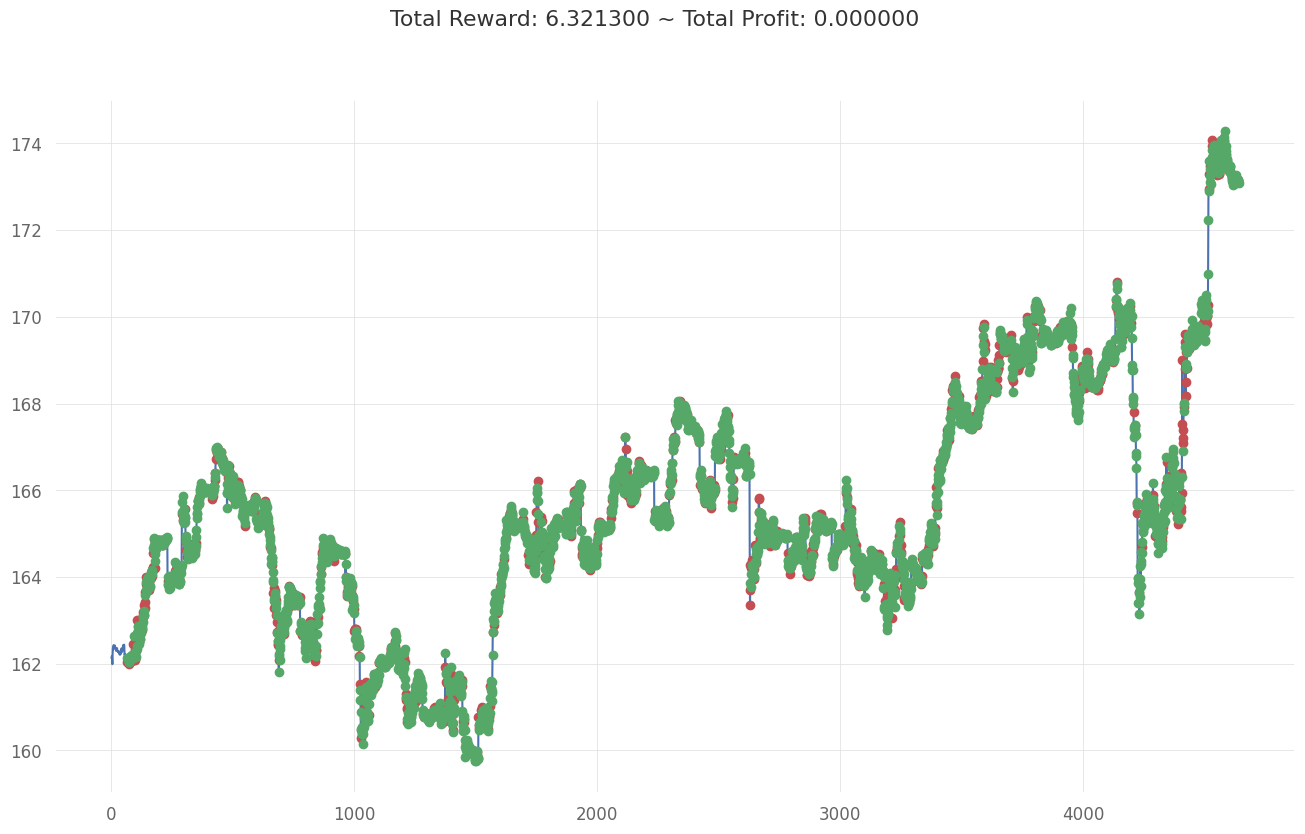

In [ ]:
#Plot the results
plt.figure(figsize=(16,9))
env.render_all()
plt.show()

[Performance Metrics]

                           Strategy
-------------------------  ----------
Start Period               2023-03-31
End Period                 2023-05-05
Risk-Free Rate             0.0%
Time in Market             22.0%

Cumulative Return          -100.0%
CAGR﹪                     -100.0%

Sharpe                     -8.18
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -6.23
Sortino                    -7.27
Smart Sortino              -5.54
Sortino/√2                 -5.14
Smart Sortino/√2           -3.92
Omega                      0.0

Max Drawdown               -100.0%
Longest DD Days            35
Volatility (ann.)          9.79%
Calmar                     -1.0
Skew                       -1.47
Kurtosis                   0.31

Expected Daily %           -0.32%
Expected Monthly %         -99.24%
Expected Yearly %          -100.0%
Kelly Criterion            -1506.07%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.33%
Expected Shortfall (cVaR) 

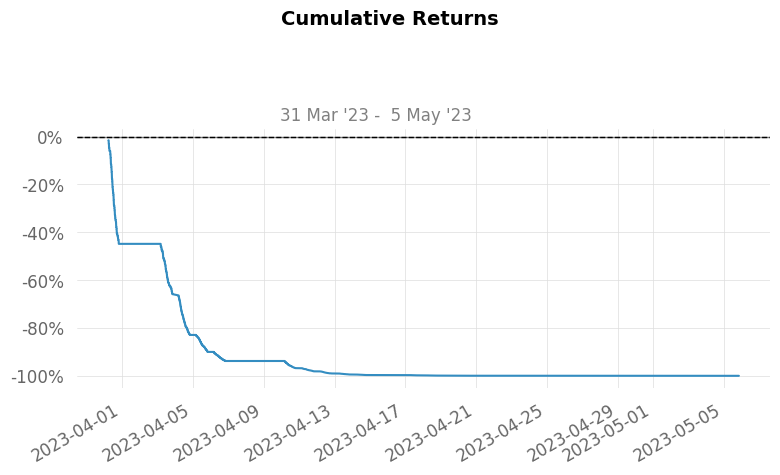

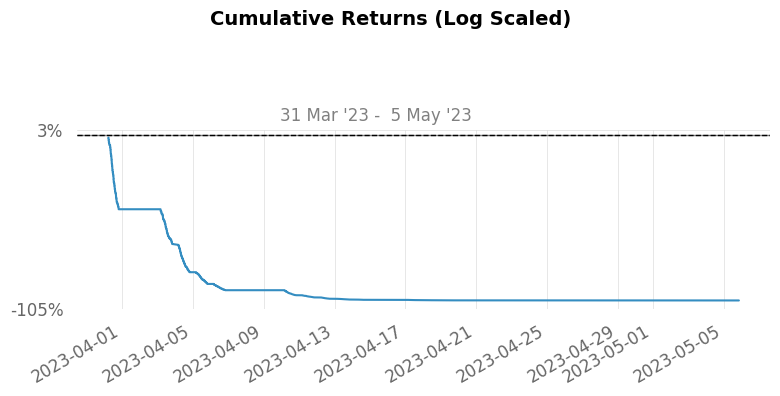

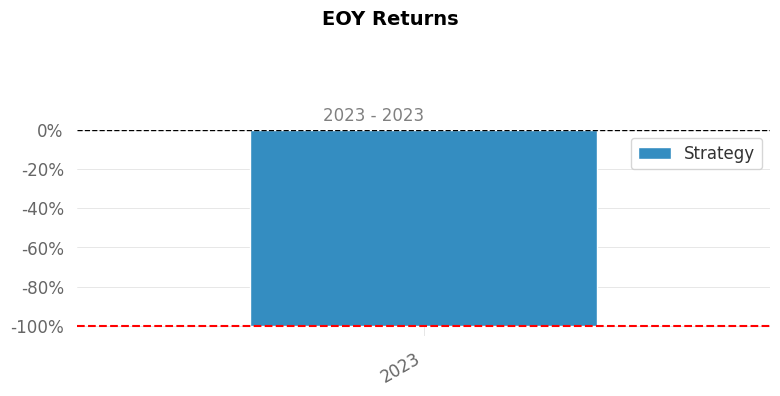

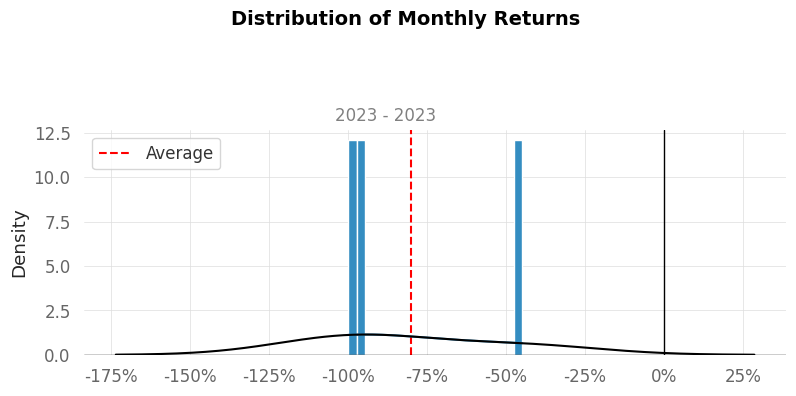

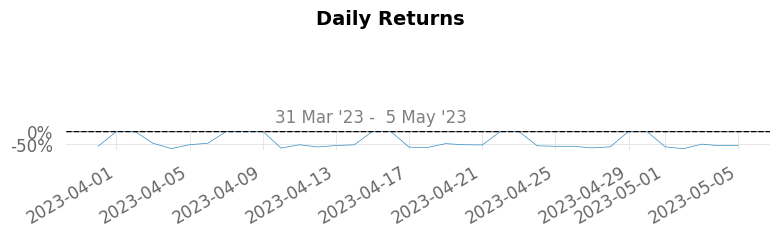

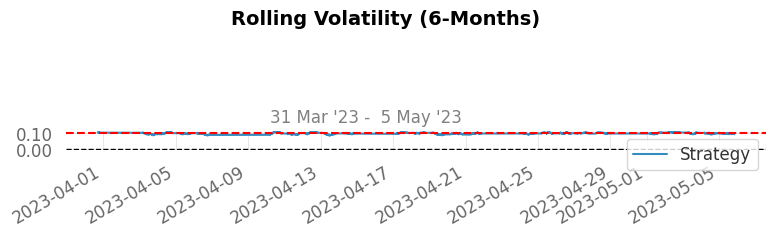

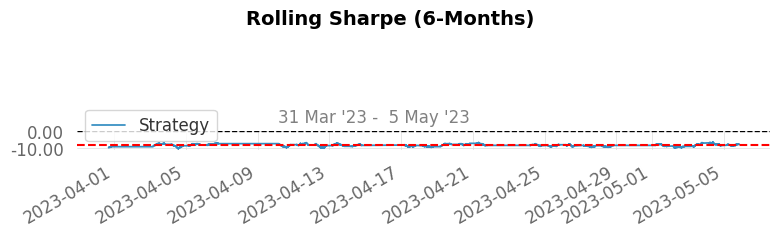

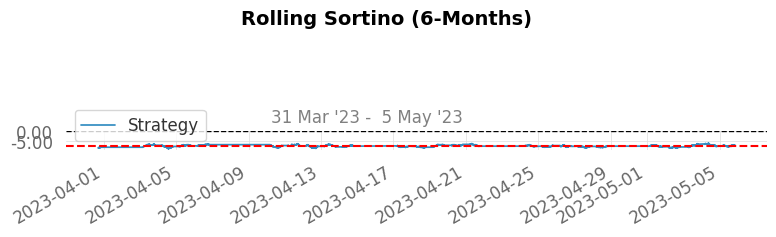

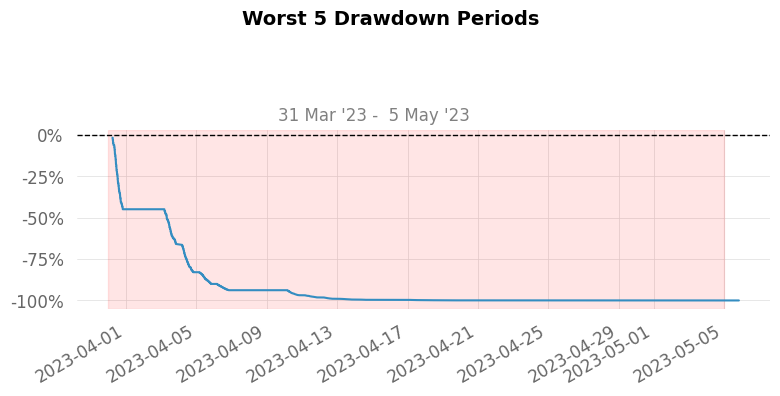

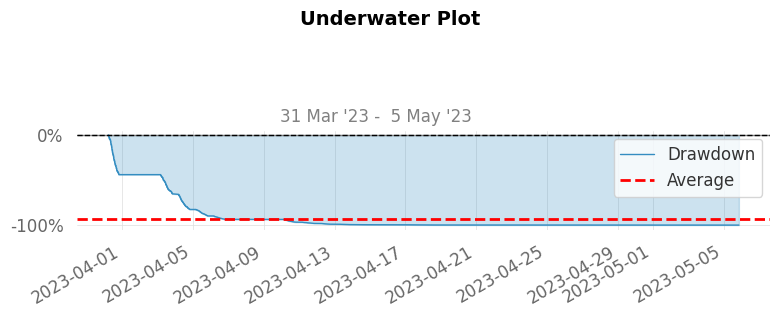

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


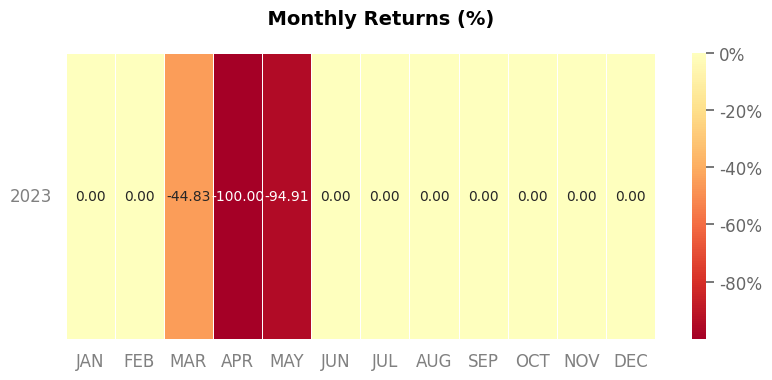

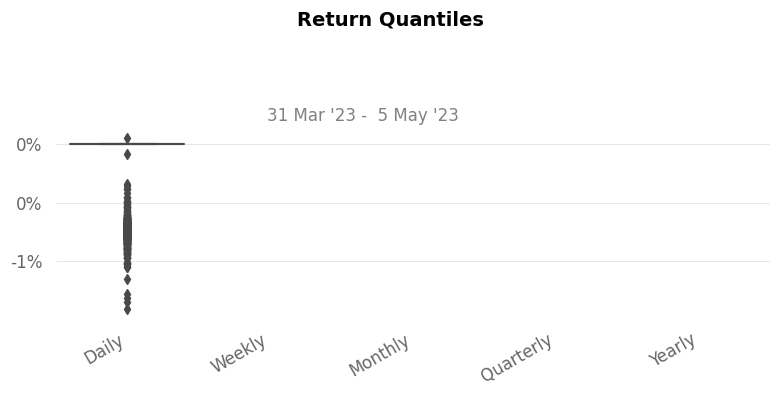

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[end_train_index+1:end_val_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)